In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_dir = pathlib.Path('/content/drive/MyDrive/Shoes_image_dataset/train/')
val_dir = pathlib.Path('/content/drive/MyDrive/Shoes_image_dataset/validate/')


image_size = (240, 240)
batch_size = 32


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)


validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 619 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [7]:
def build_model():
    base_model = MobileNetV2(
        input_shape=(240, 240, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False

    model = Sequential([
        base_model,
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(3, activation='softmax')
    ])


    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
model = build_model()
model.summary()

<ipython-input-7-dae6a155ef09>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,851 (9.24 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [8]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

EPOCHS = 30

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 175s 9s/step - accuracy: 0.3472 - loss: 1.5276 - val_accuracy: 0.3333 - val_loss: 1.1515 - learning_rate: 1.0000e-04
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.3640 - loss: 1.4665 - val_accuracy: 0.4000 - val_loss: 1.0617 - learning_rate: 1.0000e-04
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3962 - loss: 1.4158 - val_accuracy: 0.4778 - val_loss: 1.0039 - learning_rate: 1.0000e-04
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4615 - loss: 1.1405 - val_accuracy: 0.5667 - val_loss: 0.9627 - learning_rate: 1.0000e-04
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4442 - loss: 1.1521 - val_accuracy: 0.6222 - val_loss: 0.9163 - learning_rate: 1.0000e-04
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.4788 - loss: 1.1371 - val_accuracy: 0.6556 - val_loss: 0.8767 - learning_rate: 1.0000e-04
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5182 - loss

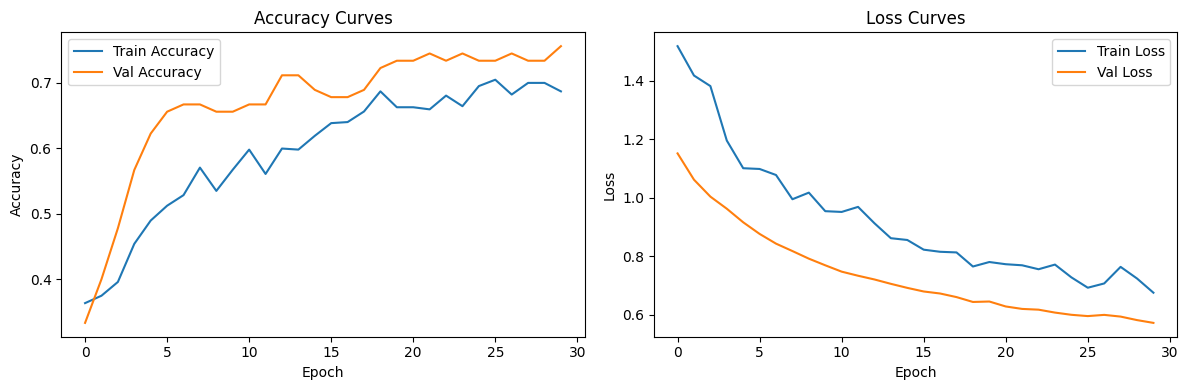

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7840 - loss: 0.5259

Final model validation accuracy: 75.56%


In [9]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

val_loss, val_acc = model.evaluate(validation_generator)
print(f"\nFinal model validation accuracy: {val_acc*100:.2f}%")

In [10]:
model.save('shoe_classifier.h5')
print("The model has been saved as 'shoe_classifier.h5'")

The model has been saved as 'shoe_classifier.h5'


In [11]:
# Test Model
def test_model(model_path, test_dir):
    model = tf.keras.models.load_model(model_path)

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    loss, accuracy = model.evaluate(test_generator)
    print(f"\nTesting accuracy: {accuracy*100:.2f}%")
    return accuracy

print("\nValidation set test results:")
test_model('shoe_classifier.h5', val_dir)


Validation set test results:


Found 90 images belonging to 3 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7840 - loss: 0.5259

Testing accuracy: 75.56%


0.7555555701255798